# setup

In [1]:
%%capture
!pip install seaborn

!pip install xarray
!pip install netcdf4
!pip install collections
!pip install scikit-image
!pip install pysteps
!pip install cartopy
!pip install beartype
!pip install pysteps
!pip install wandb

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from tqdm import tqdm
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
import tqdm

from src.utils import *
from src.helper import *
from src.utils_essential import *
from src.base_network import BaseNetwork
from src.imagen_unet import *

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr ,SR_BC_GFDL_Dataset_256
from src.dataloader_sr import QM_GFDL_LR_Dataset_256, load_dataset, GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM
from src.dataloader_sr import CustomDataset
from src.dataloader_sr import gfdl_eval

In [5]:
gfdl_ssp585_ds_fut = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("ssp370")
ds_era5_hr = era5_0_25d_256(stage='train')

dataset size (31390, 180, 288)


# Annual trend ssp585 vs QM-DM corrected ssp585

In [6]:
def compute_annual_mean_batch(data_):
    weighted_data = data_ 
    annual_mean = weighted_data.sum(dim=(2, 3))#.cpu().numpy()  
    return annual_mean.mean(0).cpu().numpy()  

def compute_trend(annual_means):
    time = np.arange(len(annual_means))  # Time as number of years
    model = LinearRegression()
    model.fit(time.reshape(-1, 1), annual_means)
    trend = model.predict(time.reshape(-1, 1))
    return trend

In [7]:
bs_eval = 365  

datasets_paths = {
    "DM1": "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_1-10y.pth",
    "DM2":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_11-20y.pth",
    "DM3": "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_21-30y.pth",
    "DM4":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_31-40y.pth",
    "DM5":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_41-50y.pth",
    "DM6":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_51-60y.pth",
    "DM7":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_61-70y.pth",
    "DM8":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_71-80y.pth",
    "DM9":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_81-90y.pth",
}

# Function to load dataset
def load_data(path, batch_size):
    dataset = load_dataset("ssp370", path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=False)

# Function to process data year by year
def process_data(name, dataloader, inverse_transform=None, downsample=True):
    annual_means = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to("cuda", non_blocking=True)  # Move batch to GPU when needed
            
            # Apply downsampling (only for DM datasets)
            if name.startswith("DM") and downsample:
                batch = ds_era5_hr.inverse_dwd_trafo(batch)
                #batch = F.avg_pool2d(batch, kernel_size=4, stride=4)
            
            if name.startswith("QM"):
                batch = batch.unsqueeze(1)  # Ensure QM UNET has the correct shape

            # Apply inverse transformation if needed
            if inverse_transform:
                batch = inverse_transform(batch)

            # Compute the annual mean for this batch
            #annual_mean = compute_annual_mean_batch(batch.to("cuda"))
            annual_mean = batch.mean(dim=(0,2,3)).cpu().numpy()
            annual_means.append(annual_mean)  # Move to CPU immediately

            # Free memory
            del batch
            torch.cuda.empty_cache()

    return np.array(annual_means)

# Dictionary to store results
annual_means_results = {}

# Process QM UNET & DM datasets
for name, path in datasets_paths.items():
    print(f"Processing {name}...")

    # Load dataset dynamically (prevents memory overflow)
    dataloader = load_data(path, bs_eval)

    # Process dataset and store results
    annual_means_results[name] = process_data(name, dataloader, None if name != "QM UNET" else ds_era5.inverse_dwd_trafo)

    # Free dataloader explicitly
    del dataloader
    torch.cuda.empty_cache()

# Add Raw GFDL (No Downsampling)
print("Processing RAW GFDL...")

ds_rawgfdl_ssp = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("ssp370")
dl_rawgfdl_ssp = DataLoader(ds_rawgfdl_ssp, batch_size=bs_eval, shuffle=False,drop_last=True)

annual_means_results["RAW GFDL"] = process_data("RAW GFDL", dl_rawgfdl_ssp, inverse_transform=None, downsample=False)

# Print output shapes for verification
for name, data_ in annual_means_results.items():
    print(f"{name}: {data_.shape}")

Processing DM1...
Processing DM2...
Processing DM3...
Processing DM4...
Processing DM5...
Processing DM6...
Processing DM7...
Processing DM8...
Processing DM9...
Processing RAW GFDL...
dataset size (31390, 180, 288)
DM1: (10, 1)
DM2: (10, 1)
DM3: (10, 1)
DM4: (10, 1)
DM5: (10, 1)
DM6: (10, 1)
DM7: (10, 1)
DM8: (10, 1)
DM9: (6, 1)
RAW GFDL: (86, 1)


In [ ]:
dm_gfdl_annual_means = np.concatenate([
    annual_means_results["DM1"], 
    annual_means_results["DM2"], 
    annual_means_results["DM3"], 
    annual_means_results["DM4"], 
    annual_means_results["DM5"],
    annual_means_results["DM6"],
    annual_means_results["DM7"],
    annual_means_results["DM8"],
    annual_means_results["DM9"]
], axis=0)
print("DM GFDL Annual Means Shape:", dm_gfdl_annual_means.shape)

raw_gfdl_annual_means = annual_means_results["RAW GFDL"]
print("Raw GFDL Annual Means Shape:", raw_gfdl_annual_means.shape)

# Compute trends
dm_trend = compute_trend(dm_gfdl_annual_means)
raw_gfdl_trend = compute_trend(raw_gfdl_annual_means)

print("Trend Lengths:", len(dm_trend), len(raw_gfdl_trend))

# Define actual years corresponding to data points
start_year = 2015
end_year = start_year + len(dm_trend)  # Adjust based on dataset length

years_dm = np.arange(start_year, start_year + len(dm_gfdl_annual_means))
years_raw_gfdl = np.arange(start_year, start_year + len(raw_gfdl_annual_means))

plt.figure(figsize=(10, 6))


# Plot annual means
plt.plot(years_dm, dm_gfdl_annual_means, color='purple', alpha=0.7, label="DM at 0.25°")
plt.plot(years_raw_gfdl, raw_gfdl_annual_means, color='blue', alpha=0.7, label="GFDL at 1°")

# Plot trends
plt.plot(years_dm, dm_trend, color='purple', linestyle='--')
plt.plot(years_raw_gfdl, raw_gfdl_trend, color='blue', linestyle='--')

# Customize the plot
plt.title("Annual mean precipitation trend over South America", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Precipitation [mm/day]", fontsize=14)

# Adjust x-axis labels to show real years
plt.xticks(np.arange(start_year, end_year, 10), fontsize=12)  # Tick every 10 years
plt.yticks(fontsize=12)

# Increase legend font size
plt.legend(fontsize=12)
#plt.savefig("figures_paper/trend_ssp370_annual_mean.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# local trend positive

In [9]:
bs_eval = 365  

datasets_paths = {
    "DM1": "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_1-10y.pth",
    "DM2":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_11-20y.pth",
    "DM3": "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_21-30y.pth",
    "DM4":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_31-40y.pth",
    "DM5":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_41-50y.pth",
    "DM6":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_51-60y.pth",
    "DM7":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_61-70y.pth",
    "DM8":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_71-80y.pth",
    "DM9":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_81-90y.pth",
}

# Function to load dataset
def load_data(path, batch_size):
    dataset = load_dataset("ssp370", path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=False)

# Function to process data year by year
def process_data(name, dataloader, inverse_transform=None, downsample=True):
    annual_means = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to("cuda", non_blocking=True)  # Move batch to GPU when needed
            
            # Apply downsampling (only for DM datasets)
            if name.startswith("DM") and downsample:
                batch = ds_era5_hr.inverse_dwd_trafo(batch)
                #batch = F.avg_pool2d(batch, kernel_size=4, stride=4)
            
            if name.startswith("QM"):
                batch = batch.unsqueeze(1)  # Ensure QM UNET has the correct shape

            # Apply inverse transformation if needed
            if inverse_transform:
                batch = inverse_transform(batch)

            if name.startswith("DM"):
                batch = batch[:,:,150:200,150:200]
            if name.startswith("RAW GFDL") :
                batch = batch[:, :, 37:50, 37:50]

            # Compute the annual mean for this batch
            annual_mean = batch.mean(dim=(0,2,3)).cpu().numpy()
            annual_means.append(annual_mean)  # Move to CPU immediately

            # Free memory
            del batch
            torch.cuda.empty_cache()

    return np.array(annual_means)

# Dictionary to store results
annual_means_results = {}

# Process QM UNET & DM datasets
for name, path in datasets_paths.items():
    print(f"Processing {name}...")

    # Load dataset dynamically (prevents memory overflow)
    dataloader = load_data(path, bs_eval)

    # Process dataset and store results
    annual_means_results[name] = process_data(name, dataloader, None if name != "QM UNET" else ds_era5.inverse_dwd_trafo)

    # Free dataloader explicitly
    del dataloader
    torch.cuda.empty_cache()

# Add Raw GFDL (No Downsampling)
print("Processing RAW GFDL...")

ds_rawgfdl_ssp = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("ssp370")
dl_rawgfdl_ssp = DataLoader(ds_rawgfdl_ssp, batch_size=bs_eval, shuffle=False,drop_last=True)

annual_means_results["RAW GFDL"] = process_data("RAW GFDL", dl_rawgfdl_ssp, inverse_transform=None, downsample=False)

# Print output shapes for verification
for name, data_ in annual_means_results.items():
    print(f"{name}: {data_.shape}")

Processing DM1...
Processing DM2...
Processing DM3...
Processing DM4...
Processing DM5...
Processing DM6...
Processing DM7...
Processing DM8...
Processing DM9...
Processing RAW GFDL...
dataset size (31390, 180, 288)
DM1: (10, 1)
DM2: (10, 1)
DM3: (10, 1)
DM4: (10, 1)
DM5: (10, 1)
DM6: (10, 1)
DM7: (10, 1)
DM8: (10, 1)
DM9: (6, 1)
RAW GFDL: (86, 1)


DM GFDL Annual Means Shape: (86, 1)
Raw GFDL Annual Means Shape: (86, 1)
Trend Lengths: 86 86


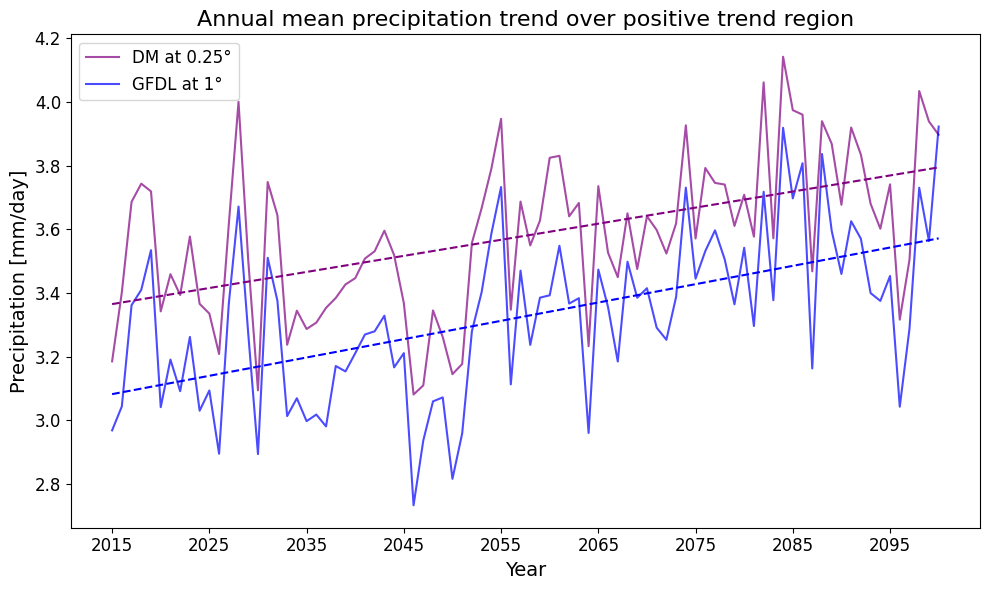

In [10]:
dm_gfdl_annual_means = np.concatenate([
    annual_means_results["DM1"], 
    annual_means_results["DM2"], 
    annual_means_results["DM3"], 
    annual_means_results["DM4"], 
    annual_means_results["DM5"],
    annual_means_results["DM6"],
    annual_means_results["DM7"],
    annual_means_results["DM8"],
    annual_means_results["DM9"]
], axis=0)
print("DM GFDL Annual Means Shape:", dm_gfdl_annual_means.shape)

raw_gfdl_annual_means = annual_means_results["RAW GFDL"]
print("Raw GFDL Annual Means Shape:", raw_gfdl_annual_means.shape)

# Compute trends
dm_trend = compute_trend(dm_gfdl_annual_means)
raw_gfdl_trend = compute_trend(raw_gfdl_annual_means)

print("Trend Lengths:", len(dm_trend), len(raw_gfdl_trend))

# Define actual years corresponding to data points
start_year = 2015
end_year = start_year + len(dm_trend)  # Adjust based on dataset length

years_dm = np.arange(start_year, start_year + len(dm_gfdl_annual_means))
years_raw_gfdl = np.arange(start_year, start_year + len(raw_gfdl_annual_means))

plt.figure(figsize=(10, 6))


# Plot annual means
plt.plot(years_dm, dm_gfdl_annual_means, color='purple', alpha=0.7, label="DM at 0.25°")
plt.plot(years_raw_gfdl, raw_gfdl_annual_means, color='blue', alpha=0.7, label="GFDL at 1°")

# Plot trends
plt.plot(years_dm, dm_trend, color='purple', linestyle='--')
plt.plot(years_raw_gfdl, raw_gfdl_trend, color='blue', linestyle='--')

# Customize the plot
plt.title("Annual mean precipitation trend over positive trend region", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Precipitation [mm/day]", fontsize=14)

# Adjust x-axis labels to show real years
plt.xticks(np.arange(start_year, end_year, 10), fontsize=12)  # Tick every 10 years
plt.yticks(fontsize=12)

# Increase legend font size
plt.legend(fontsize=12)
#plt.savefig("figures_paper/trend_ssp370_mean_positive_region.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# local trend negative

In [23]:
bs_eval = 365  

datasets_paths = {
    "DM1": "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_1-10y.pth",
    "DM2":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_11-20y.pth",
    "DM3": "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_21-30y.pth",
    "DM4":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_31-40y.pth",
    "DM5":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_41-50y.pth",
    "DM6":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_51-60y.pth",
    "DM7":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_61-70y.pth",
    "DM8":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_71-80y.pth",
    "DM9":  "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/DM_qm_gfdl_s100_e100_81-90y.pth",
}

# Function to load dataset
def load_data(path, batch_size):
    dataset = load_dataset("ssp370", path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=False)

# Function to process data year by year
def process_data(name, dataloader, inverse_transform=None, downsample=True):
    annual_means = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to("cuda", non_blocking=True)  # Move batch to GPU when needed
            
            # Apply downsampling (only for DM datasets)
            if name.startswith("DM") and downsample:
                batch = ds_era5_hr.inverse_dwd_trafo(batch)
                #batch = F.avg_pool2d(batch, kernel_size=4, stride=4)
            
            if name.startswith("QM"):
                batch = batch.unsqueeze(1)  # Ensure QM UNET has the correct shape

            # Apply inverse transformation if needed
            if inverse_transform:
                batch = inverse_transform(batch)

            # Compute the annual mean for this batch
            #annual_mean = compute_annual_mean_batch(batch.to("cuda"))
            if name.startswith("DM"):
                batch = batch[:,0:50,50:100]
            if name.startswith("RAW GFDL") :
                batch = batch[:, 0:12, 12:25]

            annual_mean = batch.mean(dim=(0,2,3)).cpu().numpy()
            annual_means.append(annual_mean)  # Move to CPU immediately

            # Free memory
            del batch
            torch.cuda.empty_cache()

    return np.array(annual_means)

# Dictionary to store results
annual_means_results = {}

# Process QM UNET & DM datasets
for name, path in datasets_paths.items():
    print(f"Processing {name}...")

    # Load dataset dynamically (prevents memory overflow)
    dataloader = load_data(path, bs_eval)

    # Process dataset and store results
    annual_means_results[name] = process_data(name, dataloader, None if name != "QM UNET" else ds_era5.inverse_dwd_trafo)

    # Free dataloader explicitly
    del dataloader
    torch.cuda.empty_cache()

# Add Raw GFDL (No Downsampling)
print("Processing RAW GFDL...")

ds_rawgfdl_ssp = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("ssp370")
dl_rawgfdl_ssp = DataLoader(ds_rawgfdl_ssp, batch_size=bs_eval, shuffle=False,drop_last=True)

annual_means_results["RAW GFDL"] = process_data("RAW GFDL", dl_rawgfdl_ssp, inverse_transform=None, downsample=False)

# Print output shapes for verification
for name, data_ in annual_means_results.items():
    print(f"{name}: {data_.shape}")

Processing DM1...
Processing DM2...
Processing DM3...
Processing DM4...
Processing DM5...
Processing DM6...
Processing DM7...
Processing DM8...
Processing DM9...
Processing RAW GFDL...
dataset size (31390, 180, 288)
DM1: (10, 1)
DM2: (10, 1)
DM3: (10, 1)
DM4: (10, 1)
DM5: (10, 1)
DM6: (10, 1)
DM7: (10, 1)
DM8: (10, 1)
DM9: (6, 1)
RAW GFDL: (86, 1)


DM GFDL Annual Means Shape: (86, 1)
Raw GFDL Annual Means Shape: (86, 1)
Trend Lengths: 86 86


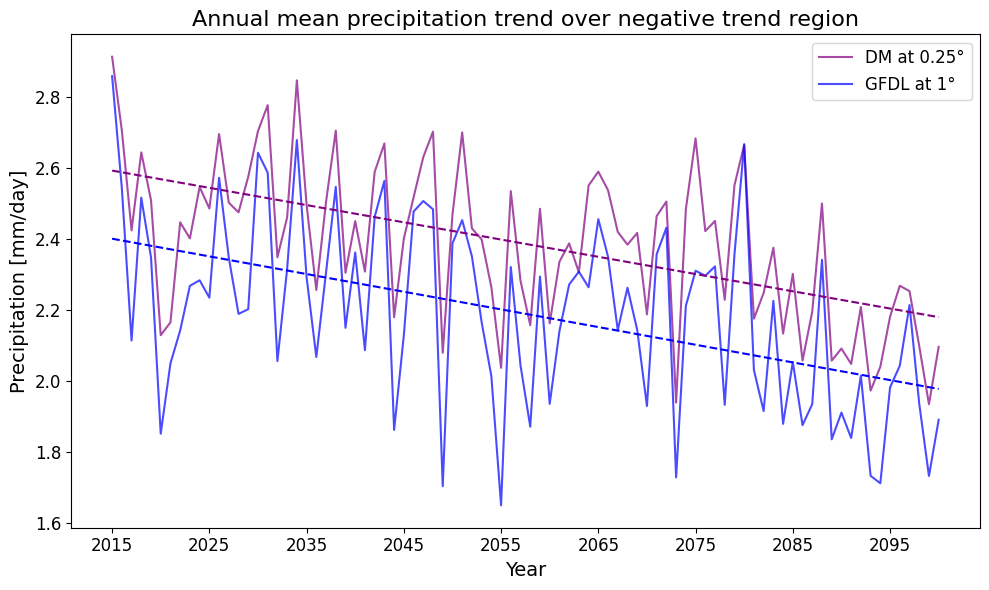

In [32]:
dm_gfdl_annual_means = np.concatenate([
    annual_means_results["DM1"], 
    annual_means_results["DM2"], 
    annual_means_results["DM3"], 
    annual_means_results["DM4"], 
    annual_means_results["DM5"],
    annual_means_results["DM6"],
    annual_means_results["DM7"],
    annual_means_results["DM8"],
    annual_means_results["DM9"]
], axis=0)
print("DM GFDL Annual Means Shape:", dm_gfdl_annual_means.shape)

raw_gfdl_annual_means = annual_means_results["RAW GFDL"]
print("Raw GFDL Annual Means Shape:", raw_gfdl_annual_means.shape)

# Compute trends
dm_trend = compute_trend(dm_gfdl_annual_means)
raw_gfdl_trend = compute_trend(raw_gfdl_annual_means)

print("Trend Lengths:", len(dm_trend), len(raw_gfdl_trend))

# Define actual years corresponding to data points
start_year = 2015
end_year = start_year + len(dm_trend)  # Adjust based on dataset length

years_dm = np.arange(start_year, start_year + len(dm_gfdl_annual_means))
years_raw_gfdl = np.arange(start_year, start_year + len(raw_gfdl_annual_means))

plt.figure(figsize=(10, 6))


# Plot annual means
plt.plot(years_dm, dm_gfdl_annual_means, color='purple', alpha=0.7, label="DM at 0.25°")
plt.plot(years_raw_gfdl, raw_gfdl_annual_means, color='blue', alpha=0.7, label="GFDL at 1°")

# Plot trends
plt.plot(years_dm, dm_trend, color='purple', linestyle='--')
plt.plot(years_raw_gfdl, raw_gfdl_trend, color='blue', linestyle='--')

# Customize the plot
plt.title("Annual mean precipitation trend over negative trend region", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Precipitation [mm/day]", fontsize=14)

# Adjust x-axis labels to show real years
plt.xticks(np.arange(start_year, end_year, 10), fontsize=12)  # Tick every 10 years
plt.yticks(fontsize=12)

# Increase legend font size
plt.legend(fontsize=12)
#plt.savefig("figures_paper/trend_ssp370_annual_mean_negative_region.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# climate change signal (future-past)/past

In [11]:
bs_val = 7300

In [12]:
ds_dm_ssp_fut = CustomDataset(folder_path='/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_3_ssp585_2014_2100_corr_plus1/'
                          ,n_files=3, mode='last')
dl_dm_ssp_fut = data.DataLoader(ds_dm_ssp_fut, batch_size=26*365, shuffle=False,drop_last=True)
dm_ssp_future = next(iter(dl_dm_ssp_fut))
dm_ssp_future = ds_era5_hr.inverse_dwd_trafo(dm_ssp_future)
dm_ssp_future = dm_ssp_future[-int(bs_val):]      # when 26 in gfdl_ssp585_ds_fut then comment out
print("DM future 0.25d 256",dm_ssp_future.shape, len(dm_ssp_future), dm_ssp_future.max() )


gfdl_ssp585_ds_fut = GFDL_P_Dataset_64_ssp_2015_2100_original_unit_before_QM("2081_2100")
gfdl_ssp585_dl_fut = data.DataLoader(gfdl_ssp585_ds_fut, batch_size=bs_val, shuffle=False,drop_last=True)
gfdl_ssp585_future = next(iter(gfdl_ssp585_dl_fut))

print("GFDL SSP585 future 1d 64 shape:",gfdl_ssp585_future.shape, len(gfdl_ssp585_future), gfdl_ssp585_future.max() )

DM future 0.25d 256 torch.Size([7300, 1, 256, 256]) 7300 tensor(501.3048)
dataset size (7300, 180, 288)
GFDL SSP585 future 1d 64 shape: torch.Size([7300, 1, 64, 64]) 7300 tensor(306.3120)


In [13]:
ds_dm_past = CustomDataset(folder_path='/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_dm_gfdl_1995_2014/'
                          ,n_files=3, mode='first')
dl_dm_past = data.DataLoader(ds_dm_past, batch_size=bs_val, shuffle=False,drop_last=True)
dm_past = next(iter(dl_dm_past))
dm_past = ds_era5_hr.inverse_dwd_trafo(dm_past)
#dm_ssp_past = F.avg_pool2d(dm_ssp_past, kernel_size=4, stride=4)

print("DM past 0.25d 256", dm_past.shape, len(dm_past) )


gfdl_past_ds = gfdl_eval("1995_2014")
gfdl_past_dl = data.DataLoader(gfdl_past_ds, batch_size=bs_val, shuffle=False,drop_last=True)
gfdl_past = next(iter(gfdl_past_dl))
gfdl_past = gfdl_past_ds.inverse_dwd_trafo(gfdl_past)

print("GFDL past 1d 64 shape:",gfdl_past.shape)

DM past 0.25d 256 torch.Size([7300, 1, 256, 256]) 7300
GFDL past 1d 64 shape: torch.Size([7300, 1, 64, 64])


In [14]:
test_alignment = False
if test_alignment == True:
    a = 223
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
    
    axs[0].imshow(gfdl_ssp585_future[a, 0])
    axs[0].set_title("GFDL SSP585 Future")
    axs[0].axis('off')
    
    axs[1].imshow(dm_ssp_future[a, 0])
    axs[1].set_title("Diffusion Model SSP585 Future")
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    a = 500
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
    axs[0].imshow(gfdl_past[a, 0])
    axs[0].set_title("GFDL SSP585 Past")
    axs[0].axis('off')
    axs[1].imshow(dm_past[a, 0])
    axs[1].set_title("Diffusion Model SSP585 Past")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
differences_dm = (dm_ssp_future.mean(0).squeeze(0) - dm_past.mean(0).squeeze(0) ) / dm_past.mean(0).squeeze(0)
differences_gfdl = (gfdl_ssp585_future.mean(0).squeeze(0) - gfdl_past.mean(0).squeeze(0) ) / gfdl_past.mean(0).squeeze(0)

In [16]:
print("dm_ssp_future", dm_ssp_future.shape)
print("differences_dm", differences_dm.shape)
print("differences_gfdl", differences_gfdl.shape)

dm_ssp_future torch.Size([7300, 1, 256, 256])
differences_dm torch.Size([256, 256])
differences_gfdl torch.Size([64, 64])


Saving to figures_paper/climate_change_signal_mean.pdf


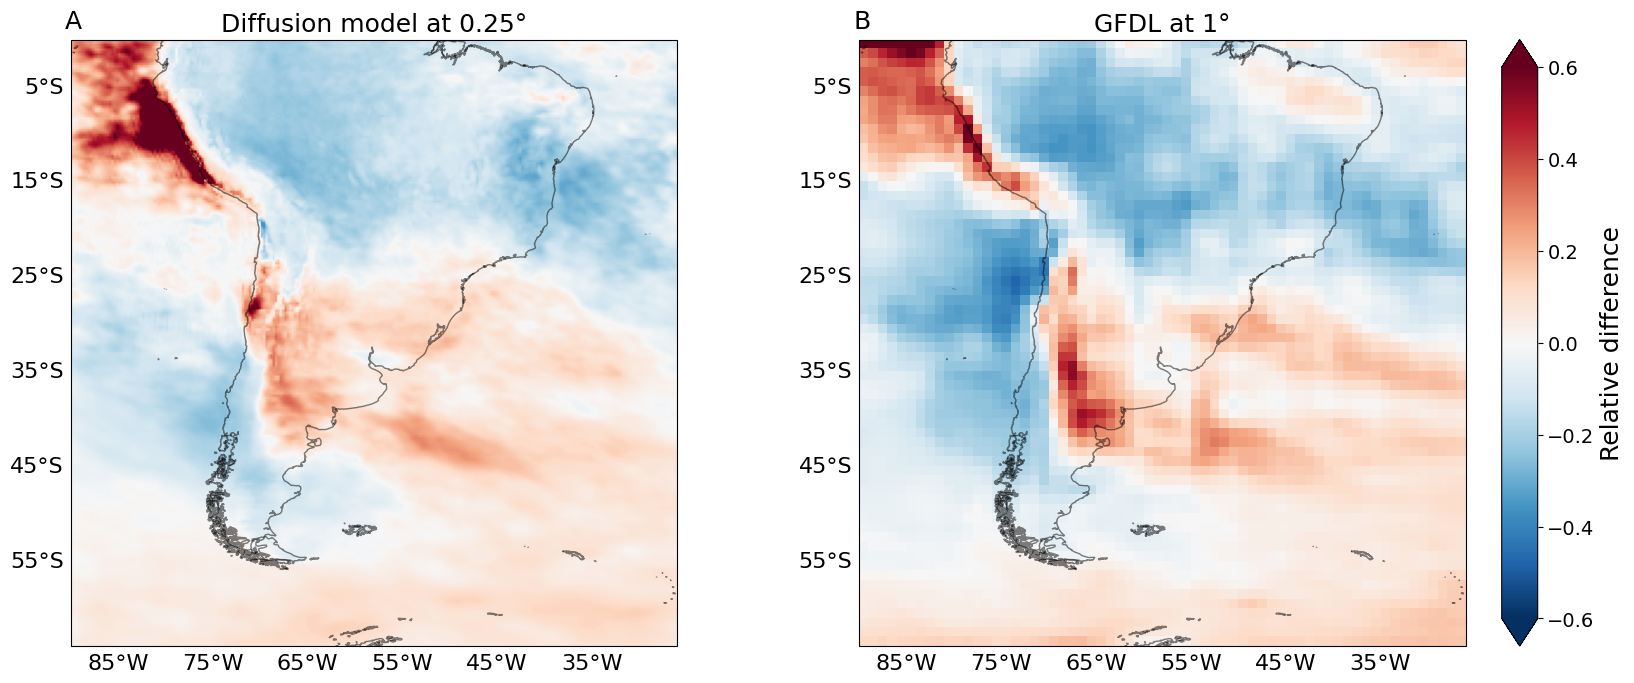

In [18]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs


def plot_precipitation(ax, data, title, min_value=3, max_value=3):
    cmap = 'RdBu_r'
    norm = plt.Normalize(vmin=min_value, vmax=max_value)
    img = ax.imshow(data, cmap , norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img
    
latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.3, hspace=0.3)

max_value = 0.6
min_value = -0.6



img1 = plot_precipitation(axes[0],differences_dm, f'', min_value, max_value)
axes[0].text(-0.01, 1.05, 'A', transform=axes[0].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'A'
axes[0].set_title(f'Diffusion model at 0.25°', fontsize=18)

img2 = plot_precipitation(axes[1], differences_gfdl, f'', min_value,  max_value)
axes[1].text(-0.01, 1.05, 'B', transform=axes[1].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'B'
axes[1].set_title(f'GFDL at 1°', fontsize=18)


# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

    
# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height]) 
cbar = fig.colorbar(img1, cax=cbar_ax,  orientation="vertical",extend="both")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Relative difference', fontsize=18)

save_figu = False
if save_figu:
    plt.savefig("figures_paper/climate_change_signal_mean.pdf")
    print("Saving to figures_paper/climate_change_signal_mean.pdf")

plt.show()

Saving to figures_paper/climate_change_signal_mean_boxes.pdf


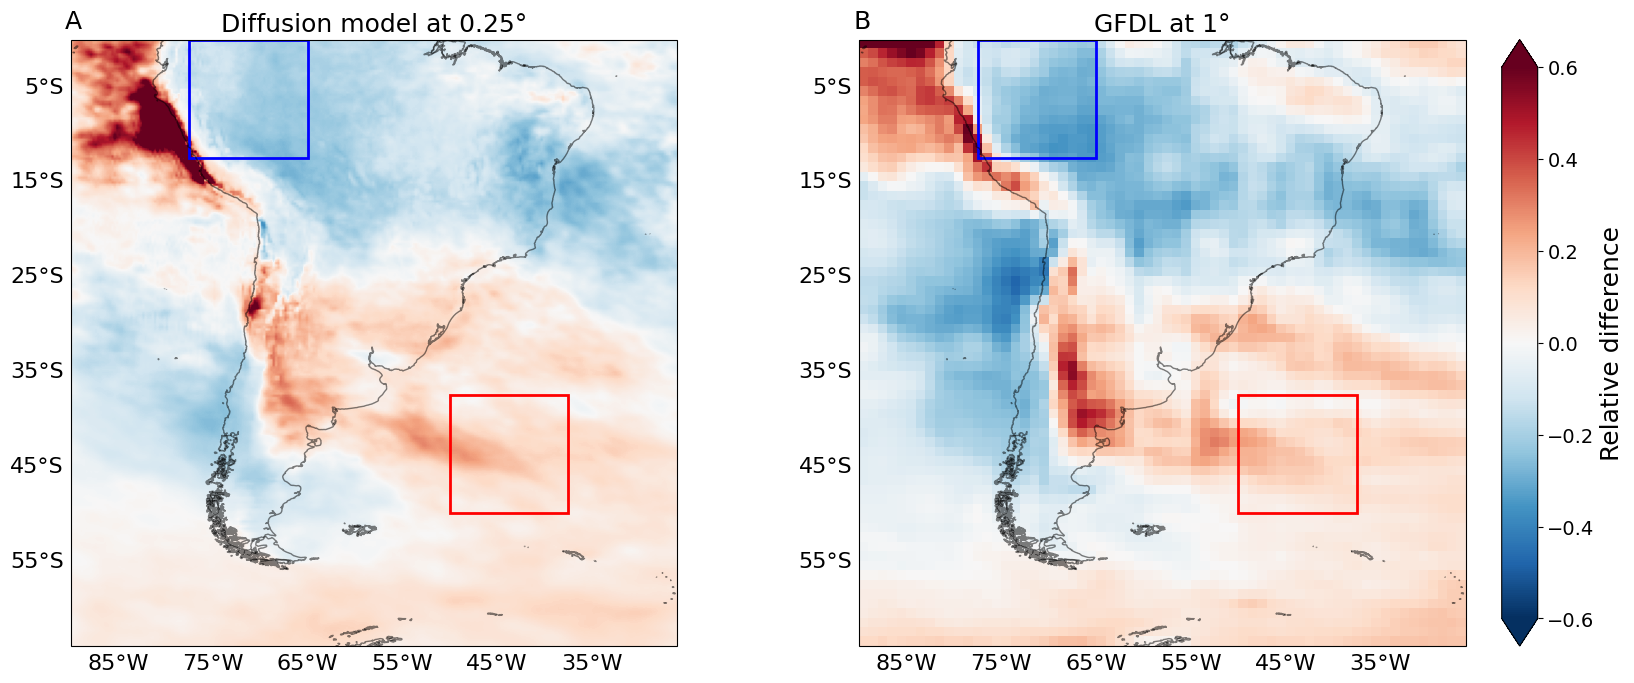

In [18]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.patches as patches

def plot_precipitation(ax, data, title, min_value=3, max_value=3):
    cmap = 'RdBu_r'
    norm = plt.Normalize(vmin=min_value, vmax=max_value)
    img = ax.imshow(data, cmap , norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img

# --- Add this function to draw rectangles ---
def add_rectangle(ax, extent, color, label=None):
    rect = patches.Rectangle(
        (extent[0], extent[2]),  # (lon_min, lat_min)
        extent[1] - extent[0],   # width
        extent[3] - extent[2],   # height
        linewidth=2,
        edgecolor=color,
        facecolor='none',
        label=label
    )
    ax.add_patch(rect)

# Example rectangle extents (edit as needed!)
extent_neg = [-50, -37.5, -50, -37.5]      # SW region
extent_pos = [-77.5, -65, -12.5, 0]        # NE region

latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.3, hspace=0.3)

max_value = 0.6
min_value = -0.6

img1 = plot_precipitation(axes[0], differences_dm, f'', min_value, max_value)
axes[0].text(-0.01, 1.05, 'A', transform=axes[0].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'A'
axes[0].set_title(f'Diffusion model at 0.25°', fontsize=18)

img2 = plot_precipitation(axes[1], differences_gfdl, f'', min_value,  max_value)
axes[1].text(-0.01, 1.05, 'B', transform=axes[1].transAxes, fontsize=18, fontweight='light', va='top')  # Add label 'B'
axes[1].set_title(f'GFDL at 1°', fontsize=18)

# --- Add the rectangles to each axis ---
add_rectangle(axes[0], extent_neg, 'red')
add_rectangle(axes[0], extent_pos, 'blue')
add_rectangle(axes[1], extent_neg, 'red')
add_rectangle(axes[1], extent_pos, 'blue')

# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height]) 
cbar = fig.colorbar(img1, cax=cbar_ax,  orientation="vertical",extend="both")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Relative difference', fontsize=18)

save_figu = False
if save_figu:
    plt.savefig("figures_paper/climate_change_signal_mean_boxes.pdf")
    print("Saving to figures_paper/climate_change_signal_mean_boxes.pdf")

plt.show()